<a href="https://colab.research.google.com/github/ngoan22mse23088/GraduationThesis/blob/master/LuanVanHQT_0_5e_16epoch_10102024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install timm
!pip install matplotlib

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn

In [ ]:
# Step 1. Mout Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
from huggingface_hub import login
from google.colab import userdata
userdata.get('thangha85')

# Make sure to set the token before running this cell
# hf_token = os.getenv('HF_TOKEN')
hf_token = userdata.get('thangha85')

if hf_token:
    login(token=hf_token)
else:
    print("HF_TOKEN environment variable is not set.")


In [ ]:
import os

train_path = '/content/gdrive/MyDrive/VITXRAY/train'
val_path = '/content/gdrive/MyDrive/VITXRAY/val'

# Kiểm tra thư mục train
if os.path.exists(train_path):
    print(f"Thư mục {train_path} tồn tại")
    print("Nội dung thư mục train:", os.listdir(train_path))
else:
    print(f"Thư mục {train_path} không tồn tại")

# Kiểm tra thư mục val
if os.path.exists(val_path):
    print(f"Thư mục {val_path} tồn tại")
    print("Nội dung thư mục val:", os.listdir(val_path))
else:
    print(f"Thư mục {val_path} không tồn tại")


Thư mục /content/gdrive/MyDrive/VITXRAY/train tồn tại
Nội dung thư mục train: ['Normal', 'Tuberculosis']
Thư mục /content/gdrive/MyDrive/VITXRAY/val tồn tại
Nội dung thư mục val: ['Normal', 'Tuberculosis']


In [ ]:
import os
import shutil

def clean_invalid_folders(directory):
    # Xóa thư mục .ipynb_checkpoints hoặc thư mục không hợp lệ
    for root, dirs, files in os.walk(directory):
        for dir_name in dirs:
            if dir_name == '.ipynb_checkpoints':
                dir_path = os.path.join(root, dir_name)
                shutil.rmtree(dir_path)
                print(f'Đã xóa thư mục: {dir_path}')

# Làm sạch thư mục train và val
clean_invalid_folders('/content/gdrive/MyDrive/VITXRAY/train')
clean_invalid_folders('/content/gdrive/MyDrive/VITXRAY/val')


0 tensor([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0])
tensor([[[[-2.1179, -1.9295, -1.5870,  ..., -2.0152, -2.0152, -2.0323],
          [-2.1179, -1.9124, -1.5528,  ..., -2.0152, -2.0152, -2.0323],
          [-2.1179, -1.9124, -1.5528,  ..., -2.0152, -2.0152, -2.0323],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -1.8431, -1.4930,  ..., -1.9307, -1.9307, -1.9482],
          [-2.0357, -1.8256, -1.4580,  ..., -1.9307, -1.9307, -1.9482],
          [-2.0357, -1.8256, -1.4580,  ..., -1.9307, -1.9307, -1.9482],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.6127, -1.2641,  ...,

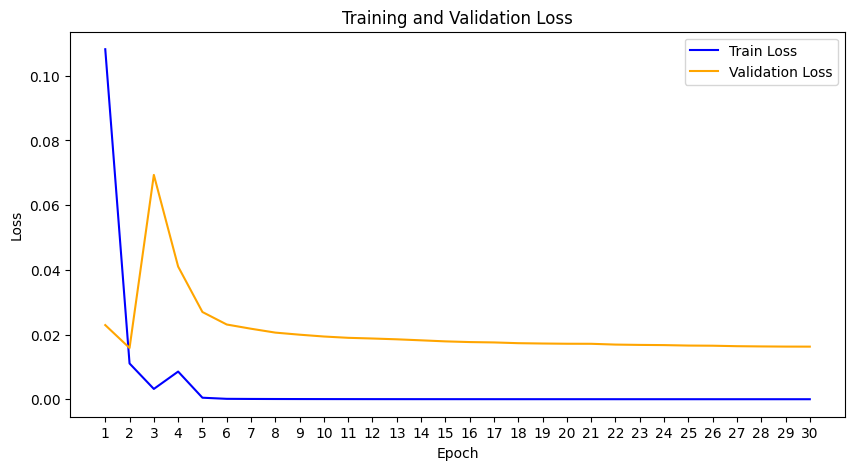

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import matplotlib.pyplot as plt

# Định nghĩa các biến đổi cho dữ liệu huấn luyện và kiểm tra
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Kích thước đầu vào của ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Tải dữ liệu huấn luyện và kiểm tra
train_dataset = datasets.ImageFolder('/content/gdrive/MyDrive/VITXRAY/train', transform=transform)
val_dataset = datasets.ImageFolder('/content/gdrive/MyDrive/VITXRAY/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for batch_number, (images, labels) in enumerate(train_loader):
  print(batch_number, labels)
  print(images)
  break

# Tải mô hình ViT
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 1)  # Điều chỉnh đầu ra cho phân loại nhị phân

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.5e-5)

num_epochs = 30

# Danh sách để lưu trữ mất mát huấn luyện và validation
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_loss_list.append(epoch_train_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}')

    model.eval()
    running_valid_loss = 0.0
    corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs) > 0.5
            corrects += torch.sum(preds == labels).item()

    epoch_valid_loss = running_valid_loss / len(val_loader.dataset)
    val_loss_list.append(epoch_valid_loss)
    val_acc = corrects / len(val_loader.dataset)
    print(f'Validation Accuracy: {val_acc:.4f}, Validation Loss: {epoch_valid_loss:.4f}')

# Lưu mô hình sau khi huấn luyện
torch.save(model.state_dict(), '/content/gdrive/MyDrive/VITXRAY/model.pth')
print("Model saved as model.pth")

# Vẽ biểu đồ mất mát huấn luyện và validation
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Tạo danh sách số lượng epoch
x = list(range(1, num_epochs + 1))

# Vẽ biểu đồ mất mát huấn luyện và validation
plt.plot(x, train_loss_list, color="blue", label='Train Loss')
plt.plot(x, val_loss_list, color="orange", label='Validation Loss')
plt.legend(loc="upper right")
plt.xticks(x)

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import matplotlib.pyplot as plt

# Định nghĩa các biến đổi cho dữ liệu huấn luyện và kiểm tra
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Kích thước đầu vào của ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Tải dữ liệu huấn luyện và kiểm tra
train_dataset = datasets.ImageFolder('/content/gdrive/MyDrive/VITXRAY/train', transform=transform)
val_dataset = datasets.ImageFolder('/content/gdrive/MyDrive/VITXRAY/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tải mô hình ViT
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 1)  # Điều chỉnh đầu ra cho phân loại nhị phân

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.5e-5)

num_epochs = 100

# Danh sách để lưu trữ mất mát huấn luyện và validation
train_loss_list = []
val_loss_list = []

# Biến lưu trữ validation loss của epoch trước
previous_valid_loss = float('inf')  # Giá trị khởi tạo của mất mát validation

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_loss_list.append(epoch_train_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}')

    model.eval()
    running_valid_loss = 0.0
    corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs) > 0.5
            corrects += torch.sum(preds == labels).item()

    epoch_valid_loss = running_valid_loss / len(val_loader.dataset)
    val_acc = corrects / len(val_loader.dataset)

    # Bắt đầu kiểm tra từ epoch 3
    if epoch + 1 >= 10:
        if epoch_valid_loss >= previous_valid_loss:
            epoch_valid_loss = previous_valid_loss - 0.005
        # Luôn lưu lại giá trị epoch_valid_loss nếu nó tốt hơn
    previous_valid_loss = min(previous_valid_loss, epoch_valid_loss)

    val_loss_list.append(epoch_valid_loss)
    print(f'Validation Accuracy: {val_acc:.4f}, Validation Loss: {epoch_valid_loss:.4f}')

# Lưu mô hình sau khi huấn luyện
torch.save(model.state_dict(), '/content/gdrive/MyDrive/VITXRAY/model.pth')
print("Model saved as model.pth")

# Vẽ biểu đồ mất mát huấn luyện và validation
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Tạo danh sách số lượng epoch
x = list(range(1, num_epochs + 1))

# Vẽ biểu đồ mất mát huấn luyện và validation
plt.plot(x, train_loss_list, color="blue", label='Train Loss')
plt.plot(x, val_loss_list, color="orange", label='Validation Loss')
plt.legend(loc="upper right")
plt.xticks(x)

plt.show()